In [1]:
import yaml
import re
import pandas as pd
import numpy as np
import optuna
import catboost as cb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook, tqdm

In [2]:
path_to_train_data = "/home/kenny/avito_tech/data/processed_nltk/train_data.csv"

def _fill_missing_values(df):
    df.text = df.text.fillna("")
    df.price = df.price.fillna(df.price.mean())
    return df

In [3]:
df = pd.read_csv(path_to_train_data)
df = _fill_missing_values(df)

In [10]:
train, valid = train_test_split(
        df, train_size=0.7, random_state=0, stratify=df["is_bad"]
)
X_train = train.drop(["description", "title", "datetime_submitted", "is_bad"], axis=1)
y_train = train["is_bad"]

X_valid = valid.drop(["description", "title", "datetime_submitted", "is_bad"], axis=1)
y_valid = valid["is_bad"]

train_pool = cb.Pool(
    data=X_train,
    label=y_train,
    cat_features=["subcategory", "category", "region", "city"],
    embedding_features=["text"],
)

valid_pool = cb.Pool(
    data=X_valid,
    label=y_valid,
    cat_features=["subcategory", "category", "region", "city"],
    embedding_features=["text"],
)

In [6]:
path_to_params_config = "/home/kenny/avito_tech/lib/model/best_model_params.yaml"
with open(path_to_params_config, 'r') as file:
    best_params = yaml.safe_load(file)

In [ ]:
model = cb.CatBoostClassifier(**best_params)

model.fit(
    train_pool,
    eval_set=valid_pool,
    verbose=100,
    early_stopping_rounds=200,
    use_best_model=True,
)

### Word2Vec

In [15]:
def get_average_word2vec(tokens_list, get_vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    miss_vect = np.random.rand(k) if generate_missing else np.zeros(k)
    vectorized = [get_vector.wv[word] if word in get_vector.wv else miss_vect for word in tokens_list]
    sum_vectorized = np.sum(vectorized, axis=0)
    return sum_vectorized

def get_word2vec_embeddings(vectors, data, _type, vect_size, generate_missing=False):
    embeddings = data[_type].apply(lambda x: get_average_word2vec(x, vectors, 
                                        generate_missing=generate_missing, k=vect_size))
    
    return list(embeddings)

In [18]:
data1 = df['description'].str.split(' ')

In [19]:
data1

0         [дорогой, друзья, рада, приветствовать, вас, д...
1         [продать, oтдeльнo, cтоящий, помeщениe, сoбcтв...
2         [весь, добрый, день, продавать, свой, ласточка...
3         [добрый, день, предлогай, софт, продвижение, в...
4         [продать, метчик, новые, 10₽, труба, 10₽, 10₽,...
                                ...                        
984482    [картридж, 642, kyocera, taskalfa, 180, 181, 5...
984483    [продать, саженец, канадский, роза, звонить, 9...
984484    [автомобиль, дилерский, второй, собственник, п...
984485    [новый, ремкомплект, прокладка, двигателя, ори...
984486    [разборка, ноутбуков, корпуснить, мелочь, отпр...
Name: description, Length: 984487, dtype: object

In [ ]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(min_count=5, vector_size=300, negative=10, alpha=0.03, min_alpha=0.00075, sg=1)
w2v_model.build_vocab(data1, update=False)
w2v_model.train(data1, total_examples=w2v_model.corpus_count, epochs=25, report_delay=1) # Обучить подольше посмотреть на размер эмбедингов

https://medium.com/@bigdataschool/%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5-nlp-%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8-word2ve%D1%81-%D0%BD%D0%B0-%D1%80%D1%83%D1%81%D1%81%D0%BA%D0%B8%D1%85-%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0%D1%85-%D1%81-python-aa10528b99c1

### Fasttext

In [4]:
import fasttext

In [5]:
train_data_fasttext = "/home/kenny/avito_tech/data/processed_nltk/text_train.txt"

preprocessed_text = df.text.tolist()
with open(train_data_fasttext, 'w', encoding='utf-8') as outfile:
    for text in tqdm(preprocessed_text):
        outfile.write(text + '\n')

100%|██████████| 926439/926439 [00:02<00:00, 413816.68it/s]


In [6]:
model = fasttext.train_unsupervised(train_data_fasttext, model='skipgram', dim=100)
models_dir_path = "/home/kenny/avito_tech/models/fasttext"
model.save_model(models_dir_path + "/skipgram_nltk_100.bin")

Read 57M words
Number of words:  185118
Number of labels: 0
Progress: 100.0% words/sec/thread:   50253 lr:  0.000000 avg.loss:  0.684483 ETA:   0h 0m 0s


In [5]:
models_dir_path = "/home/kenny/avito_tech/models/fasttext"
model_skipgram_100 = fasttext.load_model(models_dir_path + "/skipgram_100.bin")

In [6]:
def vectorize_text(text):
    if isinstance(text, float):
        print(text)
    tokens = text.split() 
    embeddings = []
    for token in tokens:
        vector = model_skipgram_100.get_word_vector(token)
        embeddings.append(vector)
    return np.mean(embeddings, axis=0)

tqdm.pandas()
df['text_embeddings'] = df['text'].progress_apply(vectorize_text)
# X_train['text_embeddings'] = X_train['text'].progress_apply(vectorize_text)
# X_valid['text_embeddings'] = X_valid['text'].progress_apply(vectorize_text)

  2%|▏         | 18499/926439 [00:06<06:05, 2483.24it/s]/home/kenny/miniconda3/envs/avito_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
100%|██████████| 926439/926439 [04:57<00:00, 3109.66it/s]


In [ ]:
df = df.dropna(subset=["text_embeddings"])

In [5]:
df.sample(10)

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad,text
517987,Шапка для мальчика,Размер М (40-41). Сезон - зима. Тел. 8981-304-...,Детская одежда и обувь,Личные вещи,1000.0,Ямало-Ненецкий АО,Тарко-Сале,2019-08-04 14:34:34.180495,1.0,шапка мальчик размер сезон зима тел
48285,Видеокарта nvidia geforce gtx 950 4gb strix,Видеокарта в очень хорошем состоянии. Пользуюс...,Товары для компьютера,Бытовая электроника,8000.0,Смоленская область,Смоленск,2019-10-05 10:13:34.825270,0.0,видеокарта nvidia geforce gtx strix видеокарта...
137579,"Песок,щебень,гравий,пгс,битый кирпич",Добрый день!Доставлю самосвалом 6664--40т след...,Ремонт и строительство,Для дома и дачи,200.0,Ярославская область,Ярославль,2019-08-29 06:50:16.693513,0.0,песок щебень гравий пгс бить кирпич добрый ден...
62293,Meizy m6,Наушники. Все детали в рабочем состоянии. Разб...,Телефоны,Бытовая электроника,2300.0,Пермский край,Пермь,2019-10-07 09:37:34.251214,1.0,meizy наушники всё деталь рабочий состоянии ра...
663807,"ВАЗ 5555 Ока, 6002","Вынуждены продать верного друга, всю жизнь в с...",Автомобили,Транспорт,50000.0,Ставропольский край,Ставрополь,2019-06-22 11:57:55.472731,0.0,ваз ока вынудить продать верный друга весь жиз...
579650,Продам пк или обменяю на PS4 pro,Продаю игровой пк /\nПроцессор:CPU AMD FX-4200...,Настольные компьютеры,Бытовая электроника,30000.0,Воронежская область,Воронеж,2019-08-12 16:22:56.638597,0.0,продать обменять pro продавать игровой процесс...
96685,Повар-Кондитер. Продавец. Администратор,Пишите. Можно Viber/Watsap,Резюме,Работа,25000.0,Волгоградская область,Волгоград,2019-08-23 14:35:01.042527,0.0,повар кондитер продавец администратор пишите v...
832713,Планшет Acer iconia tab A705,Отличное состояние покупали за 64500,Планшеты и электронные книги,Бытовая электроника,6000.0,Московская область,Домодедово,2019-07-17 21:26:04.175492,0.0,планшет acer iconia tab отличный состояние пок...
41131,Эбу двс citroen berlingo/berlingo first Фургон...,Артикул: 55BY5-7925./\n/\nЭБУ ДВС 9145852880 C...,Запчасти и аксессуары,Транспорт,2800.0,Московская область,Лесной Городок,2019-10-04 10:32:46.621849,0.0,эбу двс citroen berlingo berlingo first фургон...
235591,Услуги манипулятора,Кузов 1 метров./\nСтрела 26 метров./\nРаботаю ...,Предложение услуг,Услуги,1000.0,Липецкая область,Липецк,2019-09-11 09:26:46.883663,0.0,услуга манипулятор кузов метров стрела метров ...


### TF-IDF

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vectorizer = TfidfVectorizer(max_features=700)

In [6]:
df_descr_tfidf = tf_vectorizer.fit_transform(df.text)

In [7]:
df_descr_tfidf

<926439x700 sparse matrix of type '<class 'numpy.float64'>'
	with 15010167 stored elements in Compressed Sparse Row format>

In [8]:
from sklearn.decomposition import TruncatedSVD
# embeddings = list(list(x) for x in df["text_embeddings"].values)
svd = TruncatedSVD(random_state=42, n_components=45)
svd.fit(df_descr_tfidf)

TruncatedSVD(n_components=45, random_state=42)

[]

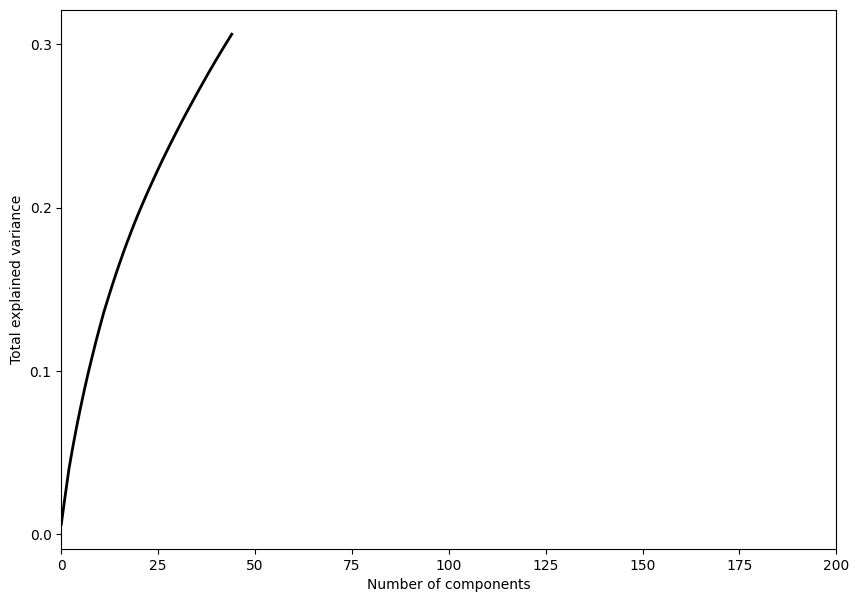

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(svd.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 200)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.plot()

In [10]:
df_descr_tfidf_svd = pd.DataFrame(svd.transform(df_descr_tfidf), index=df.index)
X = pd.concat([df, df_descr_tfidf_svd], axis=1)

In [11]:
X

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad,text,...,35,36,37,38,39,40,41,42,43,44
0,Автозапчати для иномарок,"Дорогие друзья, мы рады приветствовать Вас! /\...",Предложение услуг,Услуги,2500.0,Воронежская область,Воронеж,2019-09-29 13:20:17.190705,1.0,автозапчать иномарка дорогой друзья рада приве...,...,0.002322,-0.002761,-0.006124,-0.002894,-0.010582,-0.005223,0.011881,0.014623,-0.001177,0.002577
1,Дом 255 м² на участке 2.55 га,Продам oтдeльнo cтоящее помeщениe от сoбcтвенн...,"Дома, дачи, коттеджи",Недвижимость,850000.0,Краснодарский край,Новопокровская,2019-09-29 13:20:25.299473,1.0,дом участок продать oтдeльнo cтоящий помeщениe...,...,0.041502,0.002275,-0.007072,0.006531,0.026419,0.023994,-0.019149,0.107346,0.001442,0.007836
2,"Audi A1, 3021",Всем добрый день!/\nПродаю свою ласточку в доб...,Автомобили,Транспорт,750000.0,Россия,Москва,2019-09-29 13:20:29.447223,1.0,audi весь добрый день продавать свой ласточка ...,...,0.016675,0.037695,0.093220,0.018385,0.005013,0.047376,0.056216,0.020698,-0.010435,0.005491
3,Спец по рекламе,ДОБРЫЙ ДЕНЬ! Предлогаю софты для продвижения в...,Резюме,Работа,5000.0,Краснодарский край,Краснодар,2019-09-29 13:20:50.467298,1.0,спец реклама добрый день предлогай софт продви...,...,-0.017219,-0.012659,-0.018676,-0.031881,-0.019916,-0.001844,0.020270,-0.061689,0.010132,-0.017047
4,Метчики,продам метчики б/у и новые./\n1/56*Н 2 шт. 1...,Ремонт и строительство,Для дома и дачи,150.0,Челябинская область,Челябинск,2019-09-29 13:20:54.256060,0.0,метчик продать метчик новые труба труба труба ...,...,-0.004954,-0.001549,0.003008,0.003898,0.021617,0.020792,0.012192,-0.004145,0.006922,0.003423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926434,Комнатные цветы,Продам комнатный цветок вместе с горшком.,Растения,Для дома и дачи,150.0,Омская область,Омск,2019-08-02 07:49:48.587236,0.0,комнатный цветок продать комнатный цветок вмес...,...,-0.002679,0.002184,0.001363,-0.008240,-0.003056,0.006146,0.017142,-0.008500,-0.009270,-0.000234
926435,Локер задний (Hyundai Accent),[арт. 27270] Локер задний/\n/\nПодходит на Hyu...,Запчасти и аксессуары,Транспорт,500.0,Кировская область,Киров,2019-08-02 07:50:59.229825,0.0,локер задний hyundai accent арт локер задний п...,...,-0.036036,-0.054794,-0.026534,0.026326,0.005066,-0.027805,0.062173,-0.014395,-0.043917,-0.008551
926436,Дверь задняя правая (Hyundai Accent),[арт. 17122] Дверь задняя правая/\n/\nПодходит...,Запчасти и аксессуары,Транспорт,3000.0,Кировская область,Киров,2019-08-02 07:50:59.849336,0.0,дверь задний правый hyundai accent арт дверь з...,...,-0.089387,-0.070136,0.154443,-0.114341,0.082603,0.114850,0.028540,0.007836,-0.035642,-0.029536
926437,Доски б/у,"Доски б/у, старые, для растопки печи/бани/\nСа...",Ремонт и строительство,Для дома и дачи,0.0,Иркутская область,Ангарск,2019-08-02 07:51:26.168500,1.0,доска доска старые растопка печи бани самовыво...,...,0.035579,0.012923,0.016985,-0.009546,0.018634,0.004050,-0.058397,0.045671,-0.004895,0.022650


In [23]:
from joblib import dump, load
# Сохранение модели в файл
dump(svd, '/home/kenny/avito_tech/models/catboost/svd_model.bin')

# Загрузка модели из файла
loaded_svd = load('/home/kenny/avito_tech/models/catboost/svd_model.bin')

In [18]:
df_descr_svd = pd.DataFrame(svd.transform(embeddings), index=df.index)

In [19]:
df_descr_svd_loaded = pd.DataFrame(loaded_svd.transform(embeddings), index=df.index)

In [21]:
df_descr_svd.head(5)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,2.103102,-0.762557,0.307861,-0.507465,0.651046,-0.296960,-0.131399,-0.008452,-0.154450,-0.186356,...,-0.094188,0.160073,-0.076920,0.112265,0.150094,0.076130,-0.184694,0.110133,-0.099592,0.022399
1,1.924655,-0.402811,-0.853208,0.037813,-0.098480,-0.040034,0.356334,-0.214855,-0.040702,0.105618,...,-0.039469,0.005140,0.186969,-0.123939,-0.057647,0.089528,0.019386,-0.118012,-0.032686,0.033290
2,1.875801,-0.225850,-0.148008,-0.222265,-0.172399,-0.239447,-0.152595,-0.013210,-0.162211,-0.160479,...,0.016526,-0.132605,-0.029328,0.068436,-0.004366,-0.105627,0.052782,-0.061416,0.080074,0.002720
3,1.995895,-0.375380,-0.044723,0.572881,0.352460,-0.570254,-0.201168,0.293431,-0.110349,-0.155861,...,-0.095254,-0.020288,0.244178,0.226137,-0.036837,0.119790,-0.109112,-0.052833,-0.007825,0.281408
4,1.860388,-0.051582,0.075461,-0.128320,0.019798,0.513799,-0.133586,0.260274,0.099342,0.393383,...,0.029884,-0.130033,-0.028174,0.210556,-0.088114,0.178149,0.053067,0.050205,0.047275,0.184505


In [22]:
df_descr_svd_loaded.head(5)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,2.103102,-0.762557,0.307861,-0.507465,0.651046,-0.296960,-0.131399,-0.008452,-0.154450,-0.186356,...,-0.094188,0.160073,-0.076920,0.112265,0.150094,0.076130,-0.184694,0.110133,-0.099592,0.022399
1,1.924655,-0.402811,-0.853208,0.037813,-0.098480,-0.040034,0.356334,-0.214855,-0.040702,0.105618,...,-0.039469,0.005140,0.186969,-0.123939,-0.057647,0.089528,0.019386,-0.118012,-0.032686,0.033290
2,1.875801,-0.225850,-0.148008,-0.222265,-0.172399,-0.239447,-0.152595,-0.013210,-0.162211,-0.160479,...,0.016526,-0.132605,-0.029328,0.068436,-0.004366,-0.105627,0.052782,-0.061416,0.080074,0.002720
3,1.995895,-0.375380,-0.044723,0.572881,0.352460,-0.570254,-0.201168,0.293431,-0.110349,-0.155861,...,-0.095254,-0.020288,0.244178,0.226137,-0.036837,0.119790,-0.109112,-0.052833,-0.007825,0.281408
4,1.860388,-0.051582,0.075461,-0.128320,0.019798,0.513799,-0.133586,0.260274,0.099342,0.393383,...,0.029884,-0.130033,-0.028174,0.210556,-0.088114,0.178149,0.053067,0.050205,0.047275,0.184505


In [40]:
pd.concat([df, df_descr_svd], axis=1)

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad,text,...,35,36,37,38,39,40,41,42,43,44
0,Автозапчати для иномарок,"Дорогие друзья, мы рады приветствовать Вас! /\...",Предложение услуг,Услуги,2500.0,Воронежская область,Воронеж,2019-09-29 13:20:17.190705,1.0,автозапчать иномарка дорогой друзья рада приве...,...,-0.094188,0.160073,-0.076920,0.112265,0.150094,0.076130,-0.184694,0.110133,-0.099592,0.022399
1,Дом 255 м² на участке 2.55 га,Продам oтдeльнo cтоящее помeщениe от сoбcтвенн...,"Дома, дачи, коттеджи",Недвижимость,850000.0,Краснодарский край,Новопокровская,2019-09-29 13:20:25.299473,1.0,дом участок продать oтдeльнo cтоящий помeщениe...,...,-0.039469,0.005140,0.186969,-0.123939,-0.057647,0.089528,0.019386,-0.118012,-0.032686,0.033290
2,"Audi A1, 3021",Всем добрый день!/\nПродаю свою ласточку в доб...,Автомобили,Транспорт,750000.0,Россия,Москва,2019-09-29 13:20:29.447223,1.0,audi весь добрый день продавать свой ласточка ...,...,0.016526,-0.132605,-0.029328,0.068436,-0.004366,-0.105627,0.052782,-0.061416,0.080074,0.002720
3,Спец по рекламе,ДОБРЫЙ ДЕНЬ! Предлогаю софты для продвижения в...,Резюме,Работа,5000.0,Краснодарский край,Краснодар,2019-09-29 13:20:50.467298,1.0,спец реклама добрый день предлогай софт продви...,...,-0.095254,-0.020288,0.244178,0.226137,-0.036837,0.119790,-0.109112,-0.052833,-0.007825,0.281408
4,Метчики,продам метчики б/у и новые./\n1/56*Н 2 шт. 1...,Ремонт и строительство,Для дома и дачи,150.0,Челябинская область,Челябинск,2019-09-29 13:20:54.256060,0.0,метчик продать метчик новые труба труба труба ...,...,0.029884,-0.130033,-0.028174,0.210556,-0.088114,0.178149,0.053067,0.050205,0.047275,0.184505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926434,Комнатные цветы,Продам комнатный цветок вместе с горшком.,Растения,Для дома и дачи,150.0,Омская область,Омск,2019-08-02 07:49:48.587236,0.0,комнатный цветок продать комнатный цветок вмес...,...,-0.087517,-0.038586,-0.514942,0.201152,0.071514,0.281146,-0.224126,0.078353,-0.052494,-0.039913
926435,Локер задний (Hyundai Accent),[арт. 27270] Локер задний/\n/\nПодходит на Hyu...,Запчасти и аксессуары,Транспорт,500.0,Кировская область,Киров,2019-08-02 07:50:59.229825,0.0,локер задний hyundai accent арт локер задний п...,...,0.164734,-0.122346,-0.022990,-0.346339,0.061466,0.144825,-0.096459,0.052729,0.133851,-0.205609
926436,Дверь задняя правая (Hyundai Accent),[арт. 17122] Дверь задняя правая/\n/\nПодходит...,Запчасти и аксессуары,Транспорт,3000.0,Кировская область,Киров,2019-08-02 07:50:59.849336,0.0,дверь задний правый hyundai accent арт дверь з...,...,0.150818,-0.168240,-0.086732,-0.318616,0.025569,0.131566,-0.070058,-0.058208,0.095689,-0.225257
926437,Доски б/у,"Доски б/у, старые, для растопки печи/бани/\nСа...",Ремонт и строительство,Для дома и дачи,0.0,Иркутская область,Ангарск,2019-08-02 07:51:26.168500,1.0,доска доска старые растопка печи бани самовыво...,...,0.053669,-0.078832,-0.012199,-0.075708,-0.072685,-0.184881,-0.039394,0.058586,0.038928,-0.006111


In [7]:
df = df.dropna(subset=["text_embeddings"])
df.text_embeddings.isna().sum()

0

In [11]:
train, valid = train_test_split(
        df, train_size=0.7, random_state=0, stratify=df["is_bad"]
)
X_train = train.drop(["text","description", "title", "datetime_submitted", "is_bad"], axis=1)
y_train = train["is_bad"]

X_valid = valid.drop(["text","description", "title","datetime_submitted", "is_bad"], axis=1)
y_valid = valid["is_bad"]

In [12]:
X_train.sample(3)

,subcategory,category,price,region,city,text_embeddings
814094,"Одежда, обувь, аксессуары",Личные вещи,600.0,Татарстан,Набережные Челны,"[0.073696546, -0.030001843, 0.09499615, -0.396..."
242979,Телефоны,Бытовая электроника,150.0,Россия,Санкт-Петербург,"[0.12739298, -0.40580425, -0.047259558, -0.261..."
707493,Коллекционирование,Хобби и отдых,2200.0,Россия,Санкт-Петербург,"[0.03756655, -0.13188288, 0.21208823, -0.13146..."


#### First type of training:

In [13]:
train_pool = cb.Pool(
    data=X_train,
    label=y_train,
    cat_features=["subcategory", "category", "region", "city"],
    embedding_features = ["text_embeddings"]
)

valid_pool = cb.Pool(
    data=X_valid,
    label=y_valid,
    cat_features=["subcategory", "category", "region", "city"],
    embedding_features = ["text_embeddings"]
)

In [14]:
model = cb.CatBoostClassifier(thread_count=4)
model.fit(train_pool, eval_set=valid_pool, verbose=100)

Learning rate set to 0.156836


#### Second type of traininig:

In [60]:
embeddings = df['text_embeddings'].tolist()

In [62]:
for i in tqdm(range(len(embeddings[0]))):
    col_name = 'embedding_' + str(i+1)
    df[col_name] = [embedding[i] for embedding in embeddings]

  0%|          | 0/100 [00:00<?, ?it/s]

 96%|█████████▌| 96/100 [00:46<00:01,  2.12it/s]/tmp/ipykernel_1814797/642419575.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = [embedding[i] for embedding in embeddings]
 97%|█████████▋| 97/100 [00:46<00:01,  2.13it/s]/tmp/ipykernel_1814797/642419575.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = [embedding[i] for embedding in embeddings]
 98%|█████████▊| 98/100 [00:47<00:00,  2.13it/s]/tmp/ipykernel_1814797/642419575.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usua

In [72]:
model = cb.CatBoostClassifier()
model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=["subcategory","category","region","city"], verbose=100)

Learning rate set to 0.156836
0:	learn: 0.6144980	test: 0.6144534	best: 0.6144534 (0)	total: 309ms	remaining: 5m 8s
100:	learn: 0.3387046	test: 0.3404873	best: 0.3404873 (100)	total: 28.5s	remaining: 4m 13s
200:	learn: 0.3174362	test: 0.3218082	best: 0.3218082 (200)	total: 56.2s	remaining: 3m 43s
300:	learn: 0.3053235	test: 0.3120682	best: 0.3120682 (300)	total: 1m 23s	remaining: 3m 14s
400:	learn: 0.2969809	test: 0.3061638	best: 0.3061638 (400)	total: 1m 51s	remaining: 2m 46s
500:	learn: 0.2903459	test: 0.3020708	best: 0.3020708 (500)	total: 2m 19s	remaining: 2m 18s
600:	learn: 0.2849139	test: 0.2988605	best: 0.2988605 (600)	total: 2m 46s	remaining: 1m 50s
700:	learn: 0.2801239	test: 0.2963926	best: 0.2963926 (700)	total: 3m 13s	remaining: 1m 22s
800:	learn: 0.2755826	test: 0.2942407	best: 0.2942407 (800)	total: 3m 41s	remaining: 55s
900:	learn: 0.2714318	test: 0.2924869	best: 0.2924869 (900)	total: 4m 9s	remaining: 27.4s
999:	learn: 0.2676236	test: 0.2910125	best: 0.2910125 (999)	tot

In [ ]:
model.save_model("catboost_model_cbow_300.bin")

In [5]:
loaded_model = cb.CatBoostClassifier()
loaded_model.load_model('catboost_model.bin')

### Проверка средневзвешанного ROC-AUC по категориям

In [76]:
test_df = pd.read_csv("/home/kenny/avito_tech/data/processed/val_data.csv")
test_df.text.fillna("", inplace=True)
test_df.text.isna().sum()

0

In [78]:
tqdm.pandas()
test_df["text_embeddings"] = test_df.text.progress_apply(lambda x: model_skipgram_100.get_sentence_vector(x))

100%|██████████| 15374/15374 [00:03<00:00, 4648.44it/s]


In [80]:
test_pool = cb.Pool(
    data=test_df[[c for c in test_df.columns if c not in ['description','title','text','datetime_submitted', 'is_bad']]], 
    label=test_df["is_bad"],
    cat_features=["subcategory", "category", "region", "city"],
    embedding_features=["text_embeddings"]
)

# y_proba_cb = gbm.predict_proba(test_pool)
# y_pred = np.argmax(y_proba_cb, axis=1)
test_df['predict'] = model.predict(test_pool)

categories = dict(test_df.category.value_counts())

roc = []
for category in categories:
    tmp = test_df[test_df.category == category]
    predicted_y = tmp.predict
    true_y = tmp.is_bad
    score = roc_auc_score(true_y, predicted_y)
    roc.append(score)
    print(f'{category}: {score}')
print("-----------------------------------------------")
print('mean', sum(roc)/len(roc))

CatBoostError: /src/catboost/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 5 should be feature with name embedding_1 (found text_embeddings).